## Import Modules

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

In [2]:
!pip install kaggle

## Load the Dataset

In [3]:
import kagglehub

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [5]:
!kaggle datasets download -d jangedoo/utkface-new

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
 99% 329M/331M [00:04<00:00, 56.6MB/s]
100% 331M/331M [00:04<00:00, 71.2MB/s]


In [6]:
import zipfile
zip_ref = zipfile.ZipFile('utkface-new.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [7]:
BASE_DIR = './UTKFace/'

In [8]:
# labels - age, gender, ethnicity
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [9]:
# convert to dataframe
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()

,image,age,gender
0,./UTKFace/38_1_1_20170112235946602.jpg.chip.jpg,38,1
1,./UTKFace/26_0_1_20170117200404157.jpg.chip.jpg,26,0
2,./UTKFace/17_1_0_20170109213621558.jpg.chip.jpg,17,1
3,./UTKFace/50_0_3_20170119205125927.jpg.chip.jpg,50,0
4,./UTKFace/18_1_0_20170117193303188.jpg.chip.jpg,18,1


In [10]:
# map labels for gender
gender_dict = {0:'Male', 1:'Female'}

## Exploratory Data Analysis

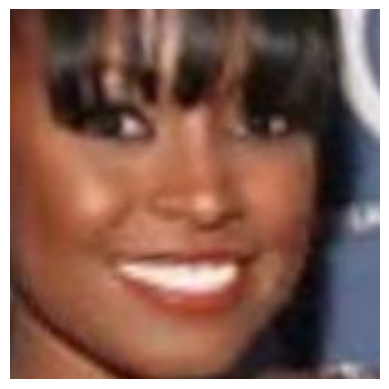

In [11]:
from PIL import Image
img = Image.open(df['image'][0])
plt.axis('off')
plt.imshow(img);

<Axes: xlabel='age', ylabel='Density'>

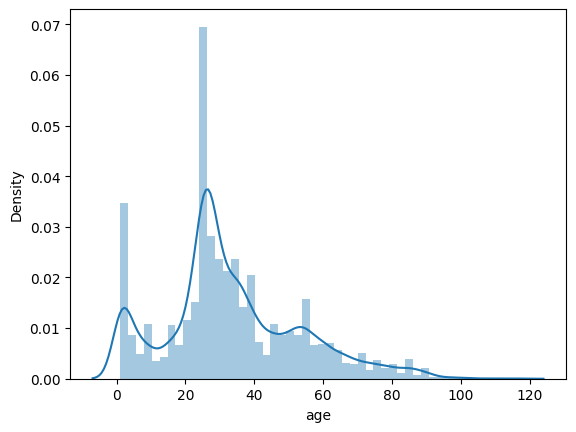

In [12]:
sns.distplot(df['age'])

<Axes: ylabel='count'>

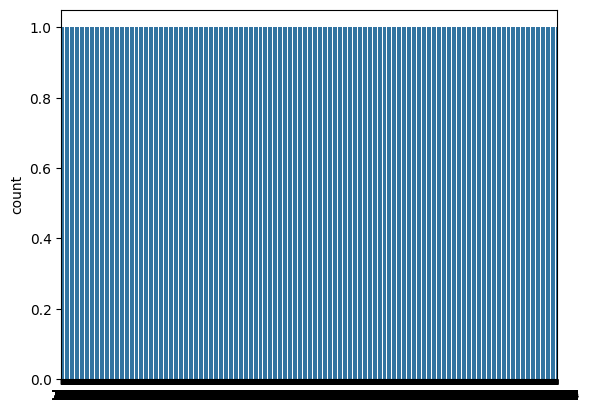

In [13]:
sns.countplot(df['gender'])

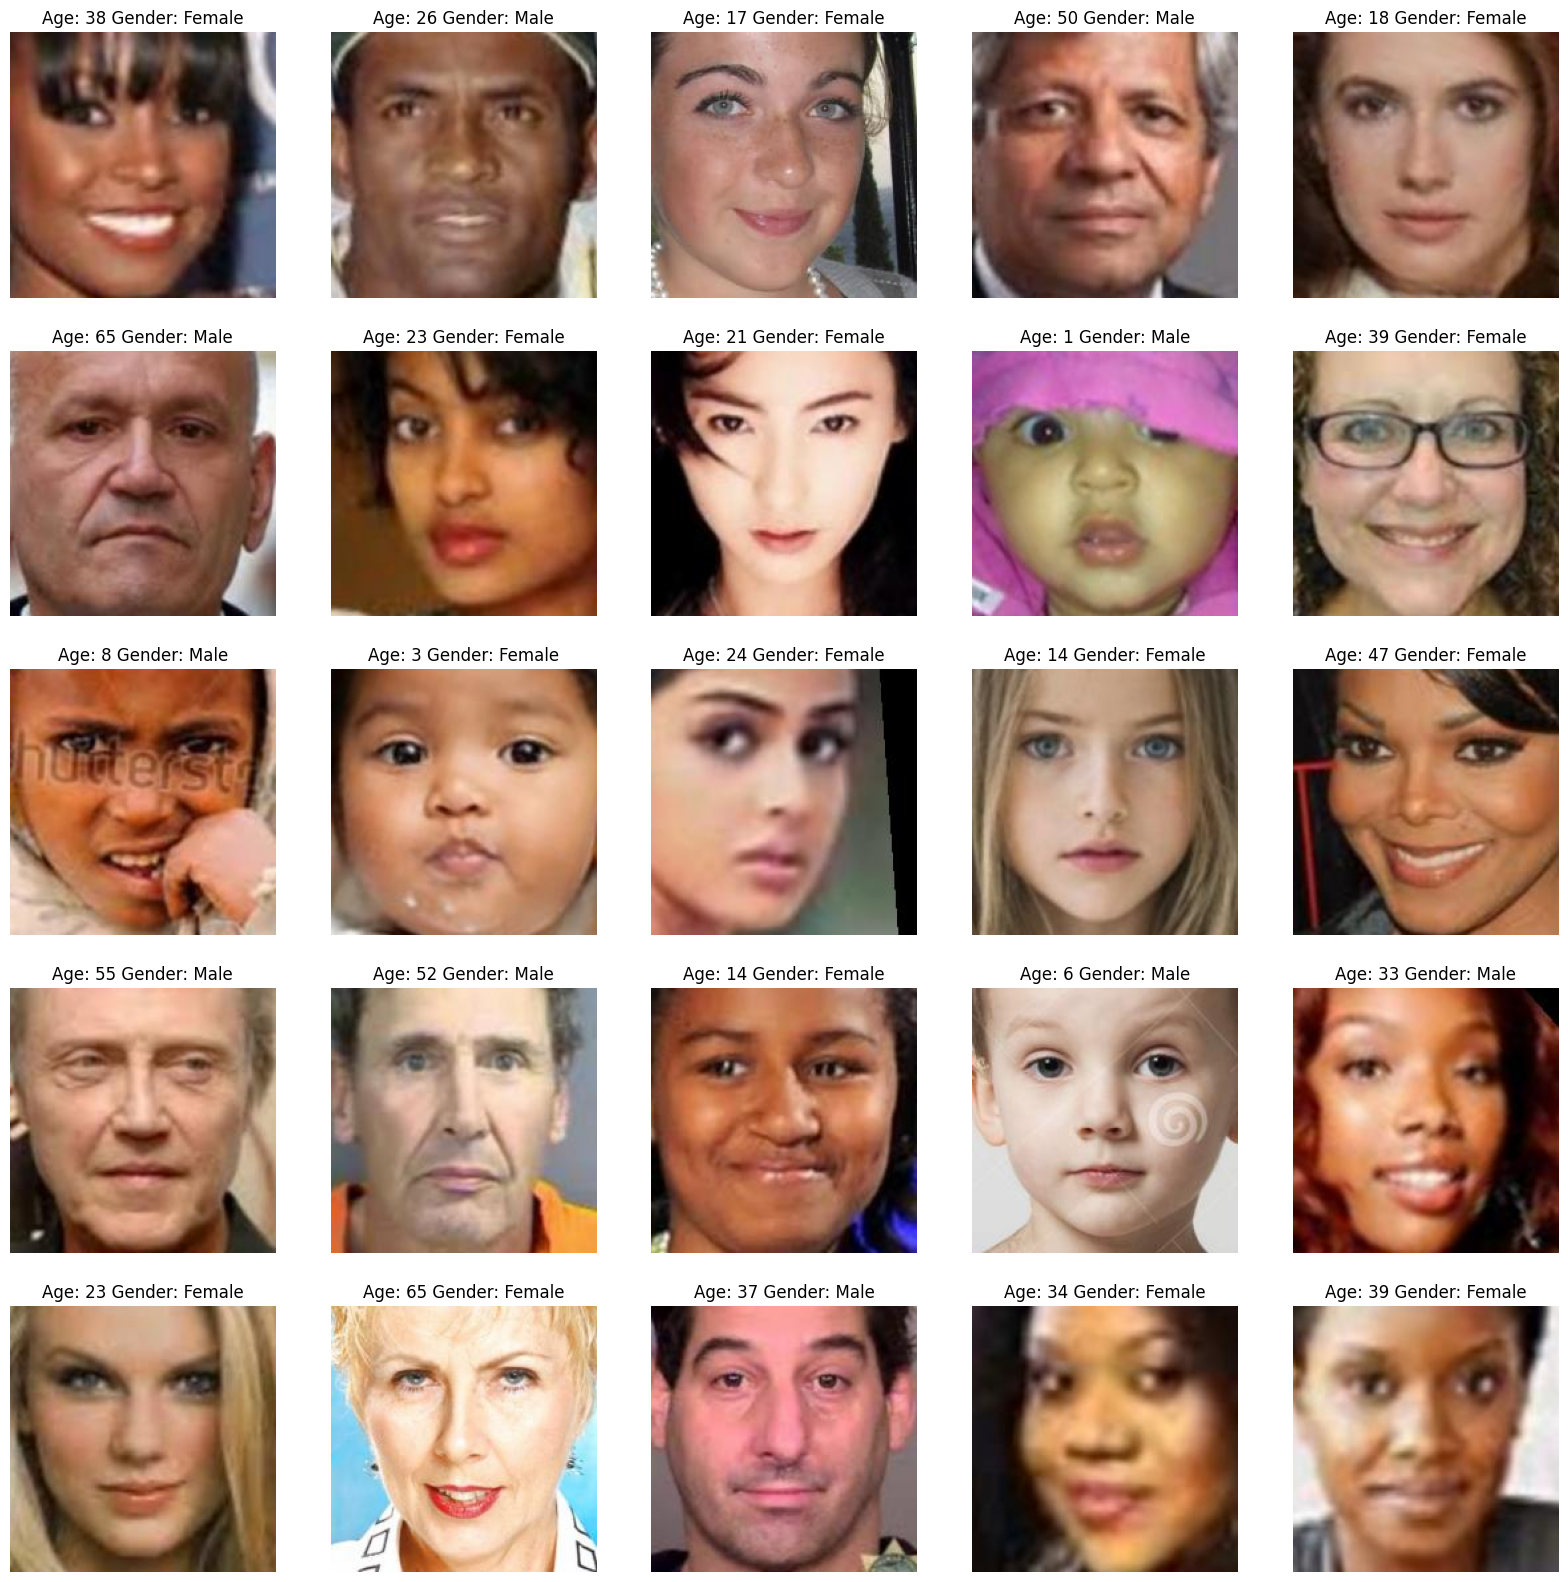

In [14]:
# to display grid of images
plt.figure(figsize=(20, 20))
files = df.iloc[0:25]

for index, file, age, gender in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

## Feature Extraction

In [15]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode='grayscale')
        img = img.resize((128, 128), Image.LANCZOS)  # Update here
        img = np.array(img)
        features.append(img)
    return features

In [16]:
X = extract_features(df['image'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [17]:
# Assuming X is the list containing your features
X = np.array(X)

# Now you can check the shape
print(X.shape)


(23708, 128, 128)


In [18]:
# normalize the images
X = X/255.0

In [19]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [20]:
input_shape = (128, 128, 1)

## Model Creation

In [21]:
inputs = Input((input_shape))
# convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

# fully connected layers
dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.4) (dense_1)
dropout_2 = Dropout(0.4) (dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy', 'mae'])

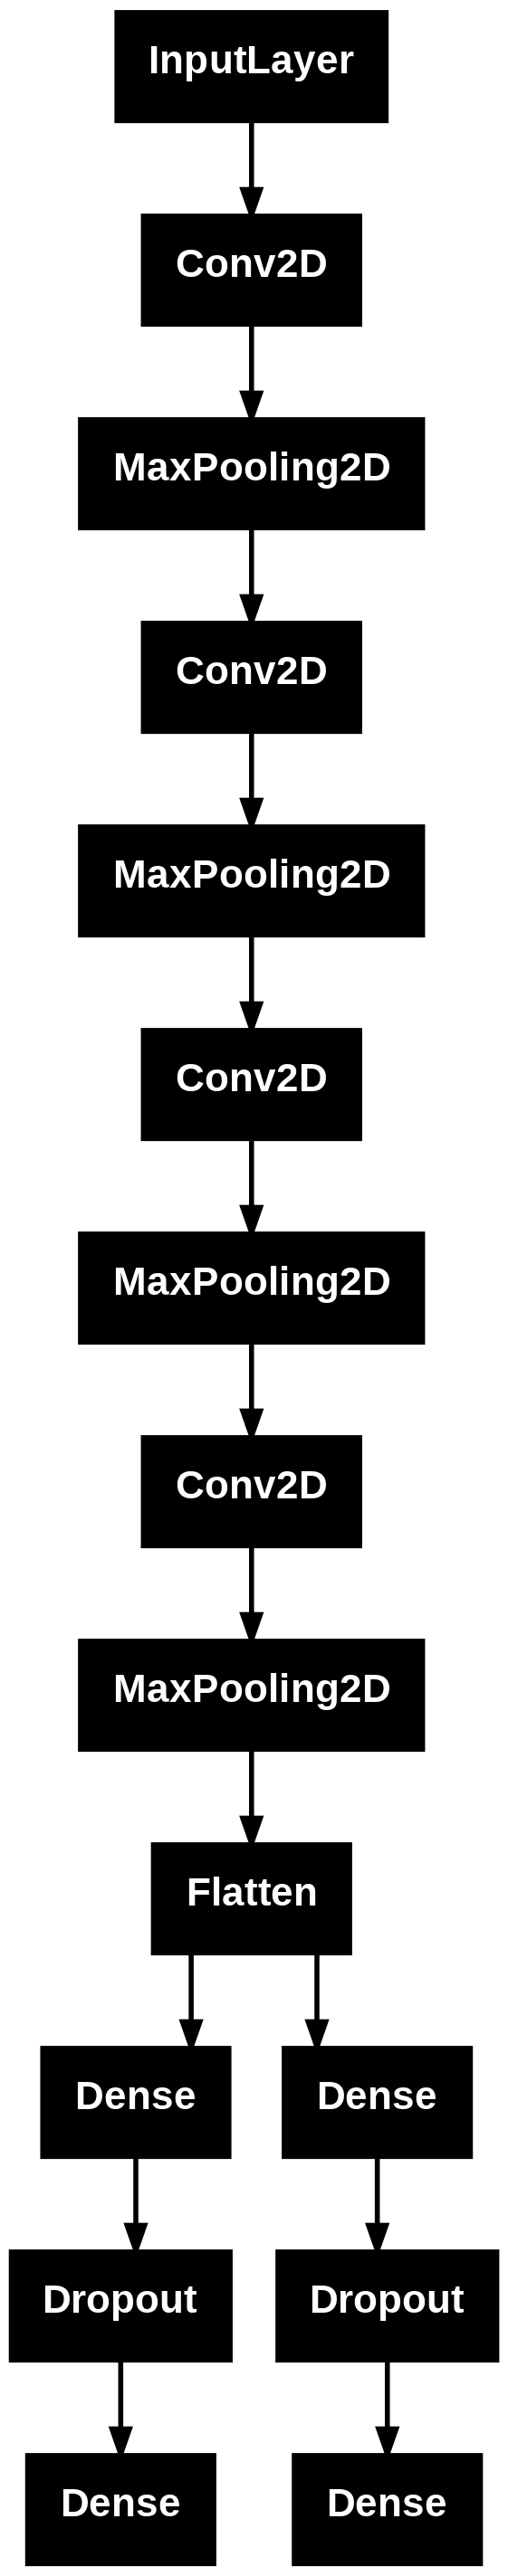

In [22]:
# plot the model
from tensorflow.keras.utils import plot_model
plot_model(model)

In [23]:
# train model
history = model.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=30, validation_split=0.2)

Epoch 1/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 28s 31ms/step - age_out_mae: 16.4749 - gender_out_accuracy: 0.5244 - loss: 17.2009 - val_age_out_mae: 12.2310 - val_gender_out_accuracy: 0.7210 - val_loss: 12.7809
Epoch 2/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - age_out_mae: 11.8529 - gender_out_accuracy: 0.7400 - loss: 12.3777 - val_age_out_mae: 10.8897 - val_gender_out_accuracy: 0.7982 - val_loss: 11.3143
Epoch 3/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - age_out_mae: 9.8783 - gender_out_accuracy: 0.7918 - loss: 10.3213 - val_age_out_mae: 8.4150 - val_gender_out_accuracy: 0.8197 - val_loss: 8.7969
Epoch 4/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - age_out_mae: 8.9021 - gender_out_accuracy: 0.8195 - loss: 9.2952 - val_age_out_mae: 8.4725 - val_gender_out_accuracy: 0.8399 - val_loss: 8.8236
Epoch 5/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - age_out_mae: 8.0368 - gender_out_accuracy: 0.8408 - loss: 8.3877 - val_age_out_mae: 7.6785 - val_gender_out_accuracy: 0.8490 - val_loss

## Plot the Results

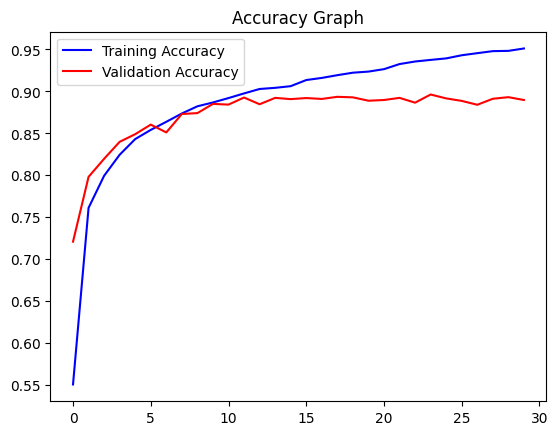

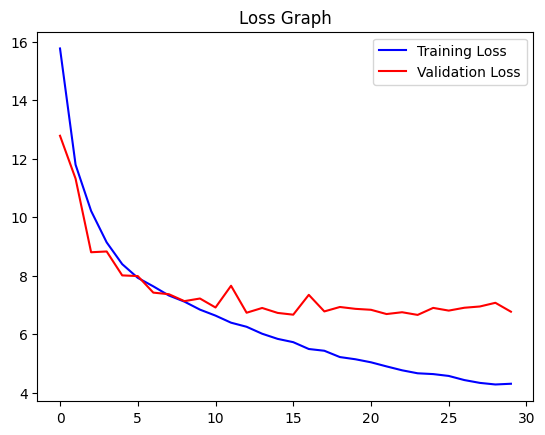

In [24]:
# plot results for gender
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

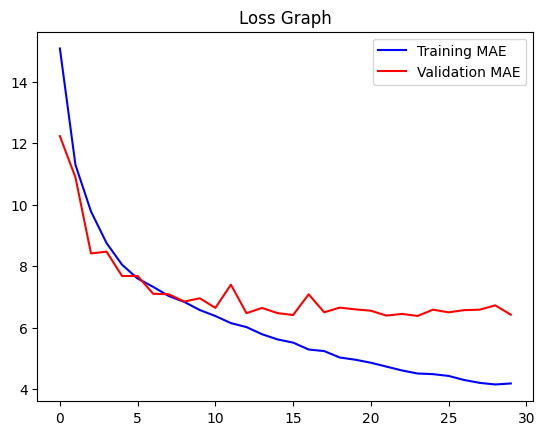

In [25]:
# plot results for age
loss = history.history['age_out_mae']
val_loss = history.history['val_age_out_mae']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training MAE')
plt.plot(epochs, val_loss, 'r', label='Validation MAE')
plt.title('Loss Graph')
plt.legend()
plt.show()

# Prediction with Test Data

Original Gender: Female Original Age: 29
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 829ms/step
Predicted Gender: Female Predicted Age: 26


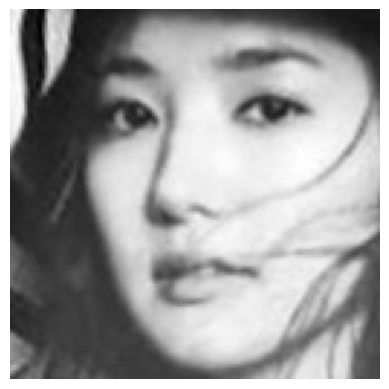

In [26]:
image_index = 100
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Female Original Age: 88
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted Gender: Female Predicted Age: 90


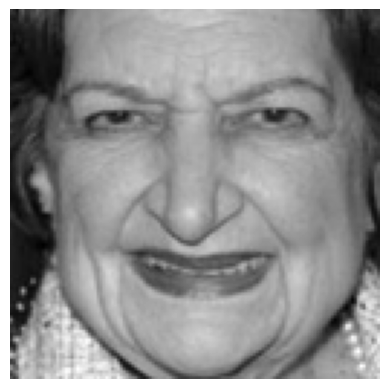

In [27]:
image_index = 3000
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Male Original Age: 23
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted Gender: Male Predicted Age: 21


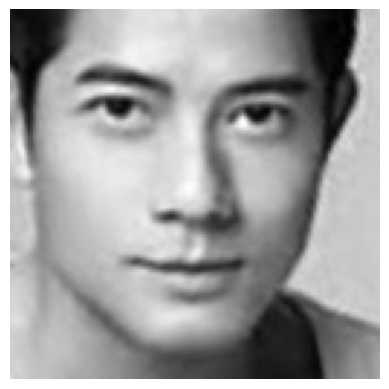

In [28]:
image_index = 10000
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');